<a href="https://colab.research.google.com/github/paveethranswam/Speech-style-transfer-and-ASR/blob/main/final_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Reference: https://github.com/tarun-bisht/wav2vec2-asr
# https://huggingface.co/blog/fine-tune-wav2vec2-english
# https://huggingface.co/docs/transformers/model_doc/wav2vec2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
pip install transformers datasets evaluate jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.1 MB/s 
     |████████████████████████████████| 451 kB 57.6 MB/s 
     |████████████████████████████████| 72 kB 1.8 MB/s 
     |████████████████████████████████| 182 kB 61.4 MB/s 
     |████████████████████████████████| 7.6 MB 50.5 MB/s 
     |████████████████████████████████| 212 kB 56.4 MB/s 
     |████████████████████████████████| 132 kB 48.2 MB/s 
     |████████████████████████████████| 127 kB 67.4 MB/s 
     |████████████████████████████████| 1.4 MB 48.0 MB/s 
     |████████████████████████████████| 2.2 MB 52.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
import transformers

In [4]:
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
from transformers import get_scheduler
from transformers import AdamW

In [5]:
from jiwer import wer
from jiwer import cer

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [8]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a3b73adc-1869-aaea-2758-b7ce441c1451)


In [9]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [10]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import os

import IPython
import requests
import torchaudio
from IPython.display import Audio, display

In [12]:
DR_VCTK_DATASET_PATH = "./DR-VCTK/"

In [13]:
os.makedirs(DR_VCTK_DATASET_PATH, exist_ok=True)
print(DR_VCTK_DATASET_PATH)

./DR-VCTK/


In [14]:
!unzip "/content/drive/My Drive/DLS_Project/Dataset/DR-VCTK/DR-VCTK.zip" -d "./DR-VCTK"

Streaming output truncated to the last 5000 lines.
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_004.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_005.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_006.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_007.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_009.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_010.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_011.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_012.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_013.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_014.wav  
  inflating: ./DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/p268_01

In [15]:
# Getting precomputed transcript mapping
import pickle
from google.colab import files

with open('./final_w2v_transcript_dictionary2.pkl', 'rb') as f:
    speaker_utterance_final = pickle.load(f)

In [16]:
drvctk_train_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='train',download=False)

In [17]:
drvctk_test_dataset = torchaudio.datasets.DR_VCTK(DR_VCTK_DATASET_PATH, subset='test',download=False)

In [18]:
print(len(drvctk_train_dataset))
print(len(drvctk_test_dataset))

11572
824


In [19]:
import re
import json
import os
import random

In [20]:
import pandas as pd
import numpy as np

In [21]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
labels = list(bundle.get_labels())
print(labels)

['-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z']


In [22]:
pre_vocab = {}

pre_vocab[""] = 0
pre_vocab["+"] = 1
pre_vocab["}"] = 2
pre_vocab["?"] = 3


for char_i in range(1,len(labels)):
  pre_vocab[labels[char_i]] = char_i+3

print(pre_vocab)

{'': 0, '+': 1, '}': 2, '?': 3, '|': 4, 'E': 5, 'T': 6, 'A': 7, 'O': 8, 'N': 9, 'I': 10, 'H': 11, 'S': 12, 'R': 13, 'D': 14, 'L': 15, 'U': 16, 'M': 17, 'W': 18, 'C': 19, 'F': 20, 'G': 21, 'Y': 22, 'P': 23, 'B': 24, 'V': 25, 'K': 26, "'": 27, 'X': 28, 'J': 29, 'Q': 30, 'Z': 31}


In [23]:
with open('./vocab.json', 'w') as vocab_file:
    json.dump(pre_vocab, vocab_file)

In [24]:
clean_train_audio_path = '/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_trainset_wav_16k/' 
noisy_train_audio_path = '/content/DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_trainset_wav_16k/' 
clean_test_audio_path = '/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset_wav_16k/' 
noisy_test_audio_path = '/content/DR-VCTK/DR-VCTK/DR-VCTK/device-recorded_testset_wav_16k/' 

In [25]:
clean_train_df_dict = {"id":[], "path":[], "sentence":[]}
noisy_train_df_dict = {"id":[], "path":[], "sentence":[]}
clean_test_df_dict = {"id":[], "path":[], "sentence":[]}
noisy_test_df_dict = {"id":[], "path":[], "sentence":[]}

for sample_id, sample in enumerate(drvctk_train_dataset):
  clean_waveform, clean_waveform_sample_rate, noisy_waveform, noisy_waveform_sample_rate, speaker_id, utterance_id, source, channel_id = sample

  file_name = speaker_id+"_"+utterance_id+".wav"
  

  sample_transcript = speaker_utterance_final[speaker_id][utterance_id]

  sample_transcript = (sample_transcript.replace('|', ' ')).rstrip()

  clean_train_df_dict["id"].append(sample_id)
  clean_train_df_dict["path"].append(os.path.join(clean_train_audio_path, file_name))
  clean_train_df_dict["sentence"].append(sample_transcript)

  noisy_train_df_dict["id"].append(sample_id)
  noisy_train_df_dict["path"].append(os.path.join(noisy_train_audio_path, file_name))
  noisy_train_df_dict["sentence"].append(sample_transcript)

for sample_id, sample in enumerate(drvctk_test_dataset):
  clean_waveform, clean_waveform_sample_rate, noisy_waveform, noisy_waveform_sample_rate, speaker_id, utterance_id, source, channel_id = sample

  file_name = speaker_id+"_"+utterance_id+".wav"
  
  sample_transcript = speaker_utterance_final[speaker_id][utterance_id]
 
  sample_transcript = (sample_transcript.replace('|', ' ')).rstrip()
  
  clean_test_df_dict["id"].append(sample_id)
  clean_test_df_dict["path"].append(os.path.join(clean_test_audio_path, file_name))
  clean_test_df_dict["sentence"].append(sample_transcript)

  noisy_test_df_dict["id"].append(sample_id)
  noisy_test_df_dict["path"].append(os.path.join(noisy_test_audio_path, file_name))
  noisy_test_df_dict["sentence"].append(sample_transcript)

clean_train_df = pd.DataFrame.from_dict(clean_train_df_dict)
noisy_train_df = pd.DataFrame.from_dict(noisy_train_df_dict)
clean_test_df = pd.DataFrame.from_dict(clean_test_df_dict)
noisy_test_df = pd.DataFrame.from_dict(noisy_test_df_dict)


In [26]:
clean_test_df.head()

,id,path,sentence
0,0,/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset...,PLEASE CALL STELLA
1,1,/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset...,ASK HER TO BRING THESE THINGS WITH HER FROM TH...
2,2,/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset...,SIX SPOONS OF FRESH SNOW PEAS FIVE THICK SLABS...
3,3,/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset...,SHE CAN SCOOP THESE THINGS INTO THREE RED BAGS...
4,4,/content/DR-VCTK/DR-VCTK/DR-VCTK/clean_testset...,WHEN THE SUNLIGHT STRIKES RAINDROPS IN THE AIR...


In [28]:
# Set Hyperparameters
batch_size = 20
n_epochs = 20
learning_rate = .00005

In [27]:
model_name = "my_fine_tuned_wave2vec_model"
model_save_path = "/content/drive/My Drive/DLS_Project/"
os.makedirs(model_save_path, exist_ok=True)

In [29]:
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="?", pad_token="+", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [30]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, df, processor):
    self.df = df
    self.processor = processor
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sp_arr, sr = torchaudio.load(self.df["path"][idx])
    sp_arr = sp_arr[0]


    X = torch.tensor(self.processor(sp_arr, sampling_rate=16000).input_values[0])

    with self.processor.as_target_processor():
      Y = torch.tensor(self.processor(self.df["sentence"][idx]).input_ids)

      
    return {"input_values":X, "labels":Y}

In [31]:
clean_train_dataset = MyDataset(clean_train_df, processor) 
noisy_train_dataset = MyDataset(noisy_train_df, processor) 
clean_test_dataset = MyDataset(clean_test_df, processor) 
noisy_test_dataset = MyDataset(noisy_test_df, processor) 

In [32]:
def collate_function(batch, processor, padding=True, max_length=None, max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None):

  b_X = [{"input_values": sample["input_values"]} for sample in batch]

  b_Y = [{"input_ids": sample["labels"]} for sample in batch]

  features = processor.pad(
            b_X,
            padding=padding,
            max_length=max_length,
            pad_to_multiple_of=pad_to_multiple_of,
            return_tensors="pt"
        ) 
  
  with processor.as_target_processor():

    batchY = processor.pad(
        b_Y,
        padding=padding,
        max_length=max_length_labels,
        pad_to_multiple_of=pad_to_multiple_of_labels,
        return_tensors="pt"
    )

  labels = batchY["input_ids"].masked_fill(batchY.attention_mask.ne(1), -100)

  features["labels"] = labels
  
  return features


In [33]:
from functools import partial

collate_fn = partial(collate_function, processor=processor, padding=True, max_length=None, 
                     max_length_labels=None, pad_to_multiple_of=None, pad_to_multiple_of_labels=None)

In [34]:
clean_train_dataloader = torch.utils.data.DataLoader(clean_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
noisy_train_dataloader = torch.utils.data.DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
clean_test_dataloader = torch.utils.data.DataLoader(clean_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
noisy_test_dataloader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [35]:
clean_test_dataloader = torch.utils.data.DataLoader(clean_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
noisy_test_dataloader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [36]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-base-960h",
#     gradient_checkpointing=True,
#     ctc_loss_reduction="mean",
#     pad_token_id=processor.tokenizer.pad_token_id,
#     vocab_size=len(processor.tokenizer)
# )

# Have a model saved!
model = torch.load("/content/drive/My Drive/DLS_Project/my_fine_tuned_wave2vec_model.pt")

In [37]:
processor = processor.from_pretrained(
    "/content/drive/My Drive/DLS_Project/my_fine_tuned_wave2vec_model_vocab"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
model.freeze_feature_extractor()

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [39]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=n_epochs*len(clean_train_dataloader)
)

In [41]:
scaler = torch.cuda.amp.GradScaler()

In [42]:
model = model.to(device)

In [63]:
test_losses = 0
wer_results = []
cer_results = []
model.eval()
with torch.no_grad():
  for batch_idx, data in enumerate(clean_train_dataloader):

    batch = {k: v.to(device) for k, v in data.items()}

    with torch.cuda.amp.autocast():
      outputs = model(**batch)

    loss = outputs.loss

    test_losses += loss.item()

    preds = outputs.logits

    labels = data["labels"]

    preds = torch.argmax(preds, axis=-1)

    labels[labels == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(preds)

    label_str = processor.batch_decode(labels, group_tokens=False)

    wer_results.append(wer(label_str, pred_str))

    cer_results.append(cer(label_str, pred_str))

print("Test Loss: {}".format(test_losses / len(drvctk_train_dataset)))
print("Initial WER for Pretrained model: {}".format(np.mean(wer_results)))   
print("Initial CER for Pretrained model: {}".format(np.mean(cer_results))) 


Test Loss: inf
Initial WER for Pretrained model: 0.25310458291366517
Initial CER for Pretrained model: 0.16060797086570297


In [64]:
# save initial model
torch.save(model, os.path.join(model_save_path, model_name+".pt"))
processor.save_pretrained(os.path.join(model_save_path, model_name+"_vocab"))

In [65]:
import numpy as np

# Results of Training
epoch_losses = []
epoch_wer_list= []
epoch_cer_list = []
epoch_last_batch_losses= []

Training_Result = (epoch_losses, epoch_wer_list, epoch_cer_list)


In [66]:
import copy

# Train Function
def train(Training_Result_p):

  epoch_losses, epoch_wer_list, epoch_cer_list = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
  
  print("Training model")

  bst_wers = 10000

  while ((epoch <= n_epochs)):
    
    # Training
    model.train()
    train_loss = 0 # calc train loss 
    last_batch_loss = 0
    train_wers = []
    train_cers= []
    for batch_idx, data in enumerate(clean_train_dataloader):

      # move inputs to device
      batch = {k: v.to(device) for k, v in data.items()}

      with torch.cuda.amp.autocast():
        outputs = model(**batch)
      loss = outputs.loss

      train_loss += loss.item()
      last_batch_loss = loss.item()

      # Backward and optimize
      optimizer.zero_grad()

      scaler.scale(loss).backward()

      scaler.step(optimizer)

      scaler.update()

      lr_scheduler.step()

      preds = outputs.logits

      labels = data["labels"]

      preds = torch.argmax(preds, axis=-1)

      labels[labels == -100] = processor.tokenizer.pad_token_id

      pred_str = processor.batch_decode(preds)

      label_str = processor.batch_decode(labels, group_tokens=False)

      train_wers.append(wer(label_str, pred_str))

      train_cers.append(cer(label_str, pred_str))
    
    epoch_wer_list.append(np.mean(train_wers))

    epoch_cer_list.append(np.mean(train_cers))

    epoch_losses.append(train_loss / len(drvctk_train_dataset))

    # Logging
    print("Epoch: {}, Total Training Loss: {}, Batch Loss: {}, Epoch WER: {}, Epoch CER: {} \n ".format(epoch, train_loss / len(drvctk_train_dataset),last_batch_loss, np.mean(train_wers), np.mean(train_cers)))
    # increment epoch
    epoch += 1

    if np.mean(train_wers) < bst_wers:

      bst_wers = np.mean(train_wers)
      
      torch.save(model, os.path.join(model_save_path, model_name+".pt"))
      processor.save_pretrained(os.path.join(model_save_path, model_name+"_vocab"))

  
  print("Training Finished!")
  Training_Return = (epoch_losses, epoch_wer_list, epoch_cer_list)
  return Training_Return

In [67]:

res = train(Training_Result)

epoch_losses, epoch_wer_list, epoch_cer_list = res

Training model


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1, Total Training Loss: inf, Batch Loss: 0.836201548576355, Epoch WER: 1.2652583091113883, Epoch CER: 0.7211834105709519 
 
Epoch: 2, Total Training Loss: inf, Batch Loss: 0.5202354192733765, Epoch WER: 1.5602821935964881, Epoch CER: 0.9644363890950879 
 
Epoch: 3, Total Training Loss: inf, Batch Loss: 0.49960073828697205, Epoch WER: 1.1967381326343134, Epoch CER: 0.8661569888281105 
 
Epoch: 4, Total Training Loss: inf, Batch Loss: 0.42800173163414, Epoch WER: 0.9136137083238857, Epoch CER: 0.7610045237662644 
 
Epoch: 5, Total Training Loss: inf, Batch Loss: 0.6063534617424011, Epoch WER: 0.8008440732500314, Epoch CER: 0.6512770313054089 
 
Epoch: 6, Total Training Loss: inf, Batch Loss: 0.27119922637939453, Epoch WER: 0.6757811346415852, Epoch CER: 0.5881512091556959 
 
Epoch: 7, Total Training Loss: inf, Batch Loss: 0.08945413678884506, Epoch WER: 0.7227413591590456, Epoch CER: 0.6243097108350721 
 
Epoch: 8, Total Training Loss: inf, Batch Loss: 0.12793737649917603, Epoch W

In [68]:
torch.save(model, os.path.join(model_save_path, model_name+".pt"))
processor.save_pretrained(os.path.join(model_save_path, model_name+"_vocab"))

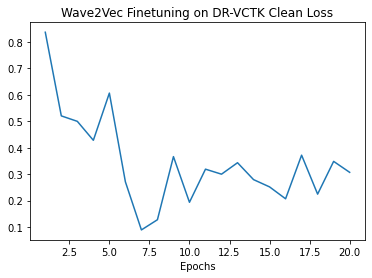

In [44]:
batch_epoch_losses = [0.836201548576355, 
                      0.5202354192733765, 
                      0.49960073828697205, 
                      0.42800173163414, 
                      0.6063534617424011, 
                      0.27119922637939453,
                      0.08945413678884506,
                      0.12793737649917603,
                      0.36634618043899536,
                      0.19385623931884766,
                      0.3189510703086853,
                      0.3000020384788513,
                      0.3432997465133667,
                      0.2794792652130127,
                      0.25197410583496094,
                      0.20703575015068054,
                      0.371806800365448,
                      0.22465115785598755,
                      0.34835848212242126,
                      0.3069944381713867]

x = np.linspace(1, 20, 20)
plt.plot(x, batch_epoch_losses)
plt.xlabel('Epochs')
plt.title("Wave2Vec Finetuning on DR-VCTK Clean Loss")
plt.show()

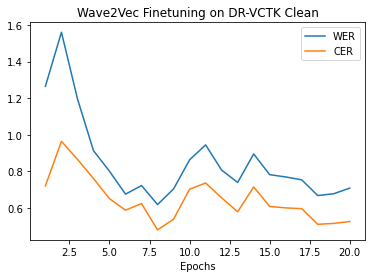

In [72]:
import numpy as np
x = np.linspace(1, 20, 20)
plt.plot(x, epoch_wer_list, label="WER")
plt.plot(x,epoch_cer_list, label="CER")
plt.xlabel('Epochs')
plt.title("Wave2Vec Finetuning on DR-VCTK Clean")
plt.legend(loc="upper right")
plt.show()

In [43]:
import numpy as np

# Results of Training
epoch_losses = []
epoch_wer_list= []
epoch_cer_list = []

Training_Result = (epoch_losses, epoch_wer_list, epoch_cer_list)

In [44]:
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=n_epochs*len(noisy_train_dataloader)
)

In [45]:
# Set Hyperparameters
batch_size = 20
n_epochs = 15
learning_rate = .00005

In [46]:
import math

In [47]:
import copy

# Train Function
def train2(Training_Result_p):

  epoch_losses, epoch_wer_list, epoch_cer_list = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch
  
  print("Training model")

  bst_wers = 10000

  while ((epoch <= n_epochs)):
    
    # Training
    model.train()
    train_loss = 0 # calc train loss
    train_wers = []
    train_cers= []
    for batch_idx, data in enumerate(noisy_train_dataloader):

      # move inputs to device
      batch = {k: v.to(device) for k, v in data.items()}

      with torch.cuda.amp.autocast():
        outputs = model(**batch)
      loss = outputs.loss

      if (loss.item() != float("inf")):
        train_loss += loss.item()
      else:
        continue

      # Backward and optimize
      optimizer.zero_grad()

      scaler.scale(loss).backward()

      scaler.step(optimizer)

      scaler.update()

      lr_scheduler.step()

      preds = outputs.logits

      labels = data["labels"]

      preds = torch.argmax(preds, axis=-1)

      labels[labels == -100] = processor.tokenizer.pad_token_id

      pred_str = processor.batch_decode(preds)

      label_str = processor.batch_decode(labels, group_tokens=False)

      train_wers.append(wer(label_str, pred_str))

      train_cers.append(cer(label_str, pred_str))
    
    epoch_wer_list.append(np.mean(train_wers))

    epoch_cer_list.append(np.mean(train_cers))

    epoch_losses.append(train_loss / len(drvctk_train_dataset))

    # Logging
    print("Epoch: {}, Total Training Loss: {}, Epoch WER: {}, Epoch CER: {} \n ".format(epoch, train_loss / len(drvctk_train_dataset), np.mean(train_wers), np.mean(train_cers)))
    # increment epoch
    epoch += 1

    if np.mean(train_wers) < bst_wers:

      bst_wers = np.mean(train_wers)
      
      torch.save(model, os.path.join(model_save_path, model_name+".pt"))
      processor.save_pretrained(os.path.join(model_save_path, model_name+"_vocab"))

  
  print("Training Finished!")
  Training_Return = (epoch_losses, epoch_wer_list, epoch_cer_list)
  return Training_Return

In [48]:
res = train2(Training_Result)

epoch_losses, epoch_wer_list, epoch_cer_list = res

Training model


/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Epoch: 1, Total Training Loss: 0.03436251694701594, Epoch WER: 0.8150858614978154, Epoch CER: 0.5921954174818789 
 
Epoch: 2, Total Training Loss: 0.029012454326615134, Epoch WER: 0.770653688453905, Epoch CER: 0.5559477868927643 
 
Epoch: 3, Total Training Loss: 0.024639438823602044, Epoch WER: 0.681742435716738, Epoch CER: 0.49161601398008475 
 
Epoch: 4, Total Training Loss: 0.022596123976316825, Epoch WER: 0.5115100561204649, Epoch CER: 0.35082904068317167 
 
Epoch: 5, Total Training Loss: 0.0206440531092091, Epoch WER: 0.5260143151767368, Epoch CER: 0.3668180984691575 
 
Epoch: 6, Total Training Loss: 0.01997728059547987, Epoch WER: 0.5620594182297832, Epoch CER: 0.4116100707191043 
 
Epoch: 7, Total Training Loss: 0.01912009968485772, Epoch WER: 0.5554024786393004, Epoch CER: 0.40125519079801103 
 
Epoch: 8, Total Training Loss: 0.018285899362219398, Epoch WER: 0.505789987985672, Epoch CER: 0.35807066287365336 
 
Epoch: 9, Total Training Loss: 0.017194444505511334, Epoch WER: 0.50

In [49]:
torch.save(model, os.path.join(model_save_path, model_name+".pt"))
processor.save_pretrained(os.path.join(model_save_path, model_name+"_vocab"))

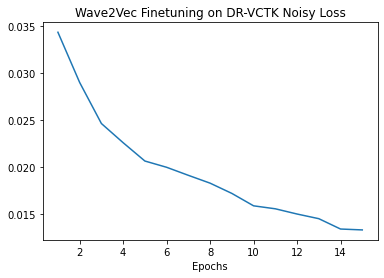

In [52]:
x = np.linspace(1, 15, 15)
plt.plot(x, epoch_losses)
plt.xlabel('Epochs')
plt.title("Wave2Vec Finetuning on DR-VCTK Noisy Loss")
plt.show()

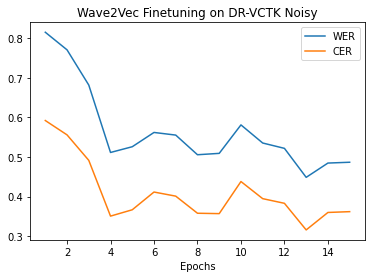

In [53]:
import numpy as np
x = np.linspace(1, 15, 15)
plt.plot(x, epoch_wer_list, label="WER")
plt.plot(x,epoch_cer_list, label="CER")
plt.xlabel('Epochs')
plt.title("Wave2Vec Finetuning on DR-VCTK Noisy")
plt.legend(loc="upper right")
plt.show()

In [54]:
# Evaluation
model.eval()
test_wers = []
test_cers= []
for batch_idx, data in enumerate(clean_test_dataloader):

  # move inputs to device
  batch = {k: v.to(device) for k, v in data.items()}

  with torch.cuda.amp.autocast():
    outputs = model(**batch)
  
  preds = outputs.logits

  labels = data["labels"]

  preds = torch.argmax(preds, axis=-1)

  labels[labels == -100] = processor.tokenizer.pad_token_id

  pred_str = processor.batch_decode(preds)

  label_str = processor.batch_decode(labels, group_tokens=False)

  test_wers.append(wer(label_str, pred_str))

  test_cers.append(cer(label_str, pred_str))

print("WER: {}".format(np.mean(test_wers)))

print("CER: {}".format(np.mean(test_cers)))


/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


WER: 0.038911039458752794
CER: 0.01401287760696503


In [55]:
# Evaluation
model.eval()
test_wers = []
test_cers= []
for batch_idx, data in enumerate(noisy_test_dataloader):

  # move inputs to device
  batch = {k: v.to(device) for k, v in data.items()}

  with torch.cuda.amp.autocast():
    outputs = model(**batch)
  
  preds = outputs.logits

  labels = data["labels"]

  preds = torch.argmax(preds, axis=-1)

  labels[labels == -100] = processor.tokenizer.pad_token_id

  pred_str = processor.batch_decode(preds)

  label_str = processor.batch_decode(labels, group_tokens=False)

  test_wers.append(wer(label_str, pred_str))

  test_cers.append(cer(label_str, pred_str))

print("WER: {}".format(np.mean(test_wers)))

print("CER: {}".format(np.mean(test_cers)))

WER: 0.10625481509670807
CER: 0.04562376111451426


In [56]:
model_path = os.path.join(model_save_path, model_name+".pt")
pipeline_path= os.path.join(model_save_path, model_name+"_vocab")

In [57]:
processor = Wav2Vec2Processor.from_pretrained(pipeline_path)
model = torch.load(model_path)


In [58]:
model = model.eval()

In [59]:
clean_waveform, clean_waveform_sample_rate, noisy_waveform, noisy_waveform_sample_rate, speaker_id, utterance_id, source, channel_id = drvctk_train_dataset[7000]

In [60]:
clean_waveform.size()

torch.Size([1, 91456])

In [61]:
input_values = processor(
      clean_waveform[0], 
      sampling_rate=clean_waveform_sample_rate, 
      return_tensors="pt"
  ).input_values.to(device)
logits = model(input_values).logits

In [62]:
predicted_ids = torch.argmax(logits, dim =-1)
transcriptions = tokenizer.decode(predicted_ids[0])
print(transcriptions)

THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPERIMPOSITION OF THE NUMBER OF BOWS


In [63]:
transcriptions

'THE ACTUAL PRIMARY RAINBOW OBSERVED IS SAID TO BE THE EFFECT OF SUPERIMPOSITION OF THE NUMBER OF BOWS'

In [64]:
sample_transcript = speaker_utterance_final[speaker_id][utterance_id]
print(sample_transcript)

THE|ACTUAL|PRIMARY|RAINBOW|OBSERVED|IS|SAID|TO|BE|THE|EFFECT|OF|SUPERIMPOSITION|OF|THE|NUMBER|OF|BOWS|
